# Predicción de reemplazo de Uniformes Ignífugos

**Proyecto final Bootcamp de Machine Learning - Código Facilito.**

La empresa donde trabajo se dedica a la elaboración de Uniformes técnicos destinados a minimizar la exposición al riesgo al que están expuestos los trabajadores en el desarrollo de ciertas actividades. Uno de esos riesgos son las altas temperaturas de corta duración ya sea por presencia de fuego o de arcos eléctricos, que se presentan en las industrias de hidrocarburos, metalúrgica, minera, gasífera o eléctrica. En ellas los uniformes ignífugos, construidos con textiles que inhiben la propagación del fuego, le dan al trabajador una ventana de tiempo para que pueda salvar su vida. Sin embargo, los textiles pueden perder sus caracteríscas ignífugas debido a diferentes condiciones poniendo en riesgo la vida de quien lo usa.

El objetivo del proyecto es predecir cuándo un uniforme ignífugo necesita ser reemplazado, basado en condiciones de uso, tipo de tejido y exposición laboral.

In [1]:
# Instalamos y cargamos librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
import joblib

# Configuración
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("✅ Librerías cargadas")

✅ Librerías cargadas


In [2]:
# Creamos el dataset con datos analizados desde nuestra experiencia (15 filas)
data = {
    'tipo_uniforme': ['Nomex', 'Modacrilico', 'Cotton_Flame_Retardant', 'Nomex', 'Modacrilico',
                     'Nomex', 'Cotton_Flame_Retardant', 'Nomex', 'Modacrilico', 'Cotton_Flame_Retardant',
                     'Nomex', 'Modacrilico', 'Cotton_Flame_Retardant', 'Nomex', 'Modacrilico'],
    'tipo_trabajo': ['Soldadura', 'Mantenimiento', 'Operacion', 'Inspeccion', 'Soldadura',
                    'Mantenimiento', 'Operacion', 'Soldadura', 'Inspeccion', 'Mantenimiento',
                    'Operacion', 'Inspeccion', 'Soldadura', 'Mantenimiento', 'Operacion'],
    'horas_mensuales': [160, 160, 160, 160, 150, 160, 160, 160, 160, 160, 160, 160, 150, 160, 160],
    'lavados_mensuales': [6, 4, 5, 4, 7, 4, 3, 6, 2, 4, 6, 2, 3, 5, 4],
    'exposicion_calor': ['Alta', 'Media', 'Media', 'Baja', 'Alta', 'Media', 'Media', 'Alta',
                        'Baja', 'Media', 'Media', 'Baja', 'Alta', 'Media', 'Baja'],
    'exposicion_quimicos': [1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0],
    'humedad_ambiente': [60, 70, 65, 50, 75, 68, 55, 80, 45, 60, 72, 50, 78, 66, 58],
    'meses_uso': [2, 4, 3, 4, 1, 4, 2, 3, 2, 5, 3, 2, 3, 5, 4],
    'estado_reemplazo': [0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1]
}

df = pd.DataFrame(data)

# Creamos un mock dataset más grande
np.random.seed(42) # Para reproducibilidad

n_samples = 50

tipo_uniforme_choices = ['Nomex', 'Modacrilico', 'Cotton_Flame_Retardant']
tipo_trabajo_choices = ['Soldadura', 'Mantenimiento', 'Operacion', 'Inspeccion']
exposicion_calor_choices = ['Baja', 'Media', 'Alta']

data_large = {
    'tipo_uniforme': np.random.choice(tipo_uniforme_choices, n_samples),
    'tipo_trabajo': np.random.choice(tipo_trabajo_choices, n_samples),
    'horas_mensuales': np.random.randint(150, 160, n_samples),
    'lavados_mensuales': np.random.randint(1, 10, n_samples),
    'exposicion_calor': np.random.choice(exposicion_calor_choices, n_samples),
    'exposicion_quimicos': np.random.randint(0, 2, n_samples),
    'humedad_ambiente': np.random.randint(40, 90, n_samples),
    'meses_uso': np.random.randint(2, 6, n_samples),
    'estado_reemplazo': np.random.randint(0, 2, n_samples) # Generamos aleatoriamente por ahora
}

df_large = pd.DataFrame(data_large)

# Concatenamos con el dataset original
df = pd.concat([df, df_large], ignore_index=True)

print("✅ Dataset creado. Shape:", df.shape)
df.head()

✅ Dataset creado. Shape: (65, 9)


,tipo_uniforme,tipo_trabajo,horas_mensuales,lavados_mensuales,exposicion_calor,exposicion_quimicos,humedad_ambiente,meses_uso,estado_reemplazo
0,Nomex,Soldadura,160,6,Alta,1,60,2,0
1,Modacrilico,Mantenimiento,160,4,Media,1,70,4,1
2,Cotton_Flame_Retardant,Operacion,160,5,Media,0,65,3,1
3,Nomex,Inspeccion,160,4,Baja,0,50,4,0
4,Modacrilico,Soldadura,150,7,Alta,1,75,1,0


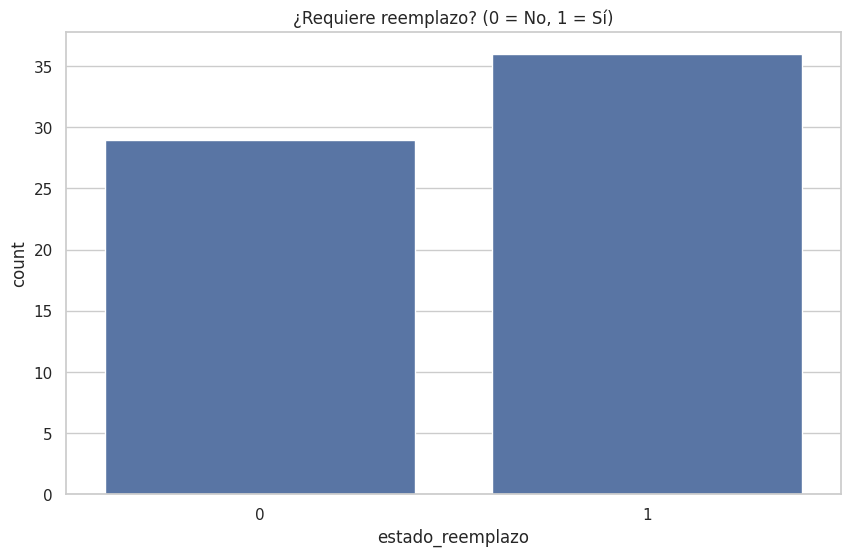

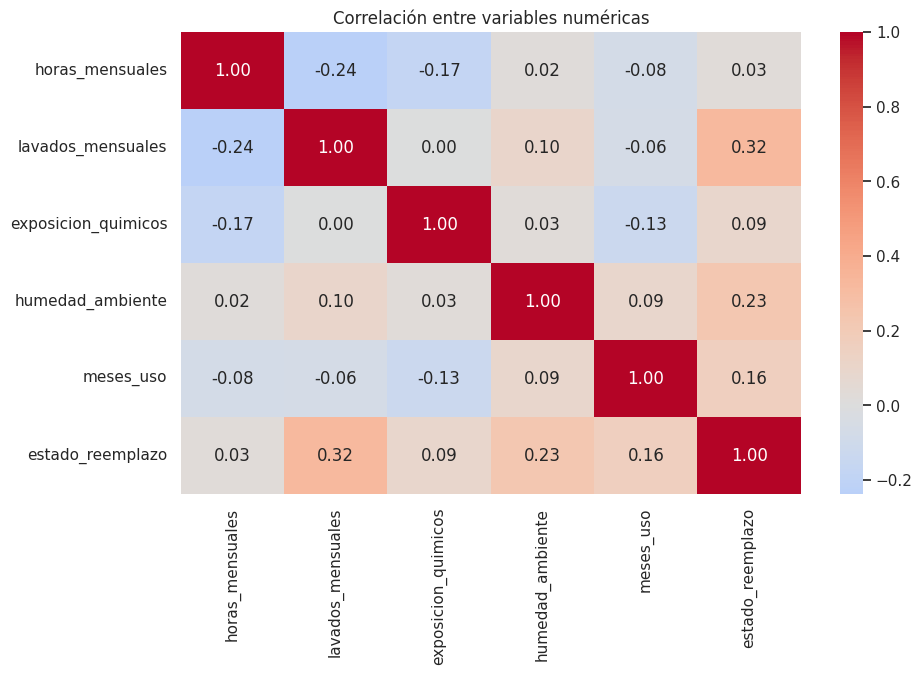

In [3]:
# Distribución de reemplazo
sns.countplot(data=df, x='estado_reemplazo')
plt.title("¿Requiere reemplazo? (0 = No, 1 = Sí)")
plt.show()

# Correlación numérica
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Correlación entre variables numéricas")
plt.show()

In [4]:
# Feature engineering
# Asignación de un peso específico a las variables para mejor acercamiento a la realidad
def create_features(df):
    df['riesgo_uso'] = (
        (df['horas_mensuales'] / 160) * 0.3 +
        (df['lavados_mensuales'] / 8) * 0.3 +
        (df['humedad_ambiente'] / 100) * 0.1 +
        (df['exposicion_quimicos']) * 0.3
    )
    calor_map = {"Baja": 1, "Media": 2, "Alta": 3}
    df['exposicion_calor_num'] = df['exposicion_calor'].map(calor_map)
    df['riesgo_uso'] += df['exposicion_calor_num'] * 0.2
    return df

df = create_features(df)

# Preprocesador
# Ajuste de las columnas para que sean manejables por el modelo
cat_cols = ['tipo_uniforme', 'tipo_trabajo']
num_cols = ['horas_mensuales', 'lavados_mensuales', 'humedad_ambiente', 'riesgo_uso', 'exposicion_calor_num']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first'), cat_cols)
])

# Entrenamiento
# Eliminamos la columna meses_uso por tratarse de una variable que solo se conoce al final del proceso y no al momento de tomar la decisión
# estado_reemplazo es el resultado que se espera obtener
X = df.drop(columns=['meses_uso', 'estado_reemplazo'])
y = df['estado_reemplazo']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

Accuracy: 0.6153846153846154
F1-Score: 0.6666666666666666
ROC-AUC: 0.5476190476190477


# Interpretación de resultados


*   Accuracy: 61.5%
 -- Es un porcentaje de acierto no muy alto
*   F1-Score: 66.6%
-- La precisión no es baja, pero tratándose de que una de las respuestas esperadas es qué tan preciso puede ser para determinar cuando sí se deben reemplazar los uniformes, es de esperar que sea mejor
*   ROC-AUC: 54.7%
-- El valor cercano al 50% me dice que el modelo no es muy preciso




In [5]:
# Definir escenarios
escenarios = [
    {"tipo_uniforme": "Nomex", "tipo_trabajo": "Soldadura", "horas_mensuales": 150, "lavados_mensuales": 6, "exposicion_calor": "Alta", "exposicion_quimicos": 1, "humedad_ambiente": 70},
    {"tipo_uniforme": "Modacrilico", "tipo_trabajo": "Mantenimiento", "horas_mensuales": 160, "lavados_mensuales": 5, "exposicion_calor": "Media", "exposicion_quimicos": 1, "humedad_ambiente": 65},
    {"tipo_uniforme": "Cotton_Flame_Retardant", "tipo_trabajo": "Operacion", "horas_mensuales": 160, "lavados_mensuales": 3, "exposicion_calor": "Baja", "exposicion_quimicos": 0, "humedad_ambiente": 60},
    {"tipo_uniforme": "Nomex", "tipo_trabajo": "Inspeccion", "horas_mensuales": 150, "lavados_mensuales": 2, "exposicion_calor": "Baja", "exposicion_quimicos": 0, "humedad_ambiente": 50},
    {"tipo_uniforme": "Modacrilico", "tipo_trabajo": "Soldadura", "horas_mensuales": 154, "lavados_mensuales": 7, "exposicion_calor": "Alta", "exposicion_quimicos": 1, "humedad_ambiente": 75}
]

df_esc = pd.DataFrame(escenarios)
df_esc = create_features(df_esc)

# Predecir
prob = model.predict_proba(df_esc)[:, 1]
pred = (prob >= 0.5).astype(int)

# Tabla de recomendaciones
recomendaciones = pd.DataFrame({
    "Tipo de Uniforme": df_esc["tipo_uniforme"],
    "Tipo de Trabajo": df_esc["tipo_trabajo"],
    "Prob. Reemplazo": (prob * 100).round(1).astype(str) + "%",
    "Acción": ["Reemplazar" if p == 1 else "No reemplazar" for p in pred]
})

print("📋 Recomendaciones de Reemplazo")
print(recomendaciones.to_string(index=False))

📋 Recomendaciones de Reemplazo
      Tipo de Uniforme Tipo de Trabajo Prob. Reemplazo        Acción
                 Nomex       Soldadura           65.0%    Reemplazar
           Modacrilico   Mantenimiento           88.0%    Reemplazar
Cotton_Flame_Retardant       Operacion           63.0%    Reemplazar
                 Nomex      Inspeccion            8.0% No reemplazar
           Modacrilico       Soldadura           47.0% No reemplazar


## ✅ Conclusión

Este modelo intenta predecir la necesidad de reemplazo de uniformes ignífugos basado en condiciones reales de uso. Dado que no existe información precisa, se analizaron puntualmente los 15 primeros elementos del dataset con base en las PQRs recibidas y en las fechas de pedido de los clientes, y los otros 50 se generaron de manera random.

Sin embargo el Accuracy considero debe ser más alto para considerar que puede usarse realmente, además, la simulación de posibles escenarios 'Recomendaciones de Reemplazo' arroja un dato que no es confiable, ya que un uniforme de cuando se expone a trabajos de soldadura es muy susceptible a dañarse por impactos en el textil, por las altas temperaturas a las que normalmente se trabaja, por lo tanto, al estar por debajo del 50%, es algo que debe revisarse mejor.

La intención de esta tabla de recomendaciones es que pueda usarse para dar un valor agregado a nuestros clientes de manera tal que puedan guiar sus decisiones de mantenimiento y compras.

Ahora bien, ¿porqué o cómo darle un valor más real a **riesgo_uso**? Esta variable pretende con base en nuestro conocimiento y a lo que dicen los ensayos que deben pasar los textiles para el cumplimiento de normas internacionales, darle mayuor importancia a unos datos que a otros, por ejemplo:

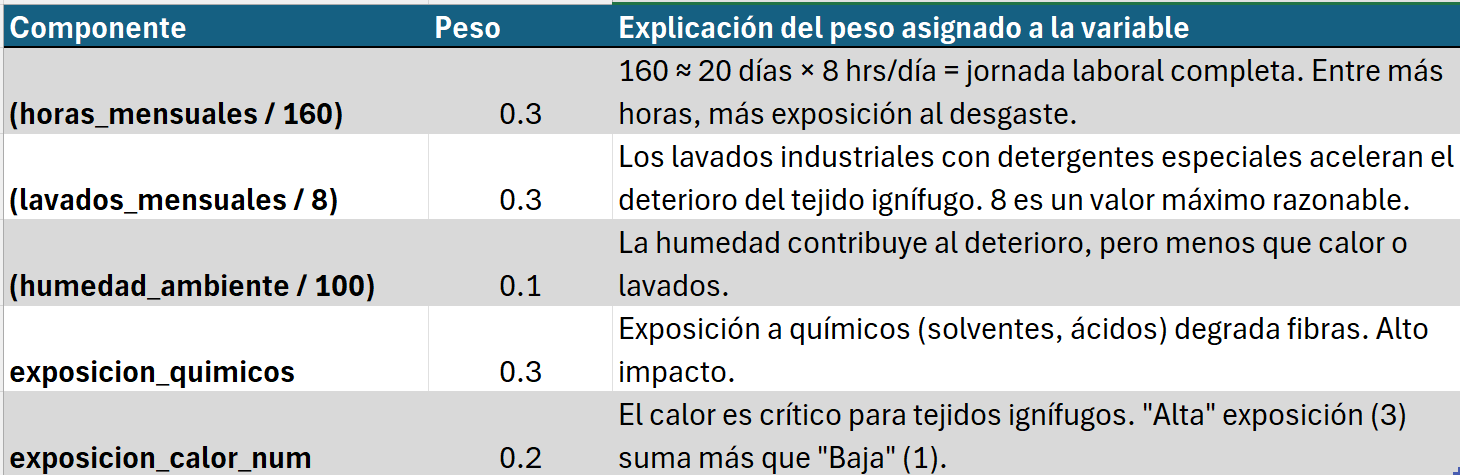

Se hizo un preprocesamiento de la información para dejarla en términos razonables para el entrenamiento del modelo, en primer lugar, **se separan las columnas de texto de las columnas numéricas**, luego **se revisan las magnitudes de las columnas numéricas** para evitar que el modelo le de más importancia a una columna por que se expresa en magnitudes más grandes, como horas_mensuales y lavados_mensuales, finalmente **las columnas de texto o categorías se convierten a números**.

**Un aprendizaje en mi caso, se da con la eliminación para el entrenamiento del modelo, de la variable 'meses_uso'**, debido a que esta información se conoce cuando ya han ocurrido los hechos, es decir, meses después de haber tomado la decisión de comprar o reemplazar un uniforme, en otras palabras, al momento de tomar la decisión de comprar los uniformes, ese dato aún no se ha concretado porque ocurre meses adelante, en cambio, usamos solo variables disponibles antes de la decisión:
- Tipo de uniforme
- Condiciones de trabajo
- Horas y lavados mensuales
- Exposición a calor/químicos
- Grado de humedad